Testin

In [4]:
import torch
import lerobot
from lerobot.common.datasets.lerobot_dataset import LeRobotDataset, LeRobotDatasetMetadata
from pprint import pprint
from lerobot.common.policies.tdmpc.modeling_tdmpc import TDMPCConfig, TDMPCPolicy
from lerobot.common.datasets.utils import dataset_to_policy_features
from lerobot.configs.types import FeatureType
import mediapy as media

In [5]:

dataset_metadata = LeRobotDatasetMetadata("lerobot/xarm_lift_medium")
features = dataset_to_policy_features(dataset_metadata.features)
output_features = {key: ft for key, ft in features.items() if ft.type is FeatureType.ACTION}
input_features = {key: ft for key, ft in features.items() if key not in output_features}

# Create TDMPC config
cfg = TDMPCConfig(
    input_features=input_features,
    output_features=output_features,
    # use_mpc=True,
)

delta_timestamps = {
    "observation.image": [i / dataset_metadata.fps for i in cfg.observation_delta_indices],
    "observation.state": [i / dataset_metadata.fps for i in cfg.observation_delta_indices],
    "action": [i / dataset_metadata.fps for i in cfg.action_delta_indices],
    "next.reward": [i / dataset_metadata.fps for i in cfg.reward_delta_indices],
}
dataset = LeRobotDataset('lerobot/xarm_lift_medium', delta_timestamps=delta_timestamps)

Resolving data files:   0%|          | 0/800 [00:00<?, ?it/s]

In [6]:
dataset.fps

15

In [5]:
import lerobot.common.envs.factory
# import gymnasium as gym
# import gym_xarm 
# env = gym.make(
#     "gym_xarm/XarmLift-v0",
#     obs_type="pixels_agent_pos",
#     max_episode_steps=300,
# )

env_cfg = lerobot.common.envs.factory.make_env_config("xarm")
env = lerobot.common.envs.factory.make_env(env_cfg)

In [4]:
observation, info = env.reset()

/media/ssd/eugene/robotic_manipulation/lerobot_venv/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


""

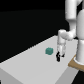

In [5]:
import mediapy as media
media.show_image(observation["pixels"][0])


In [23]:
dataset

LeRobotDataset({
    Repository ID: 'lerobot/xarm_lift_medium',
    Number of selected episodes: '800',
    Number of selected samples: '20000',
    Features: '['observation.image', 'observation.state', 'action', 'episode_index', 'frame_index', 'timestamp', 'next.reward', 'next.done', 'index', 'task_index']',
})',

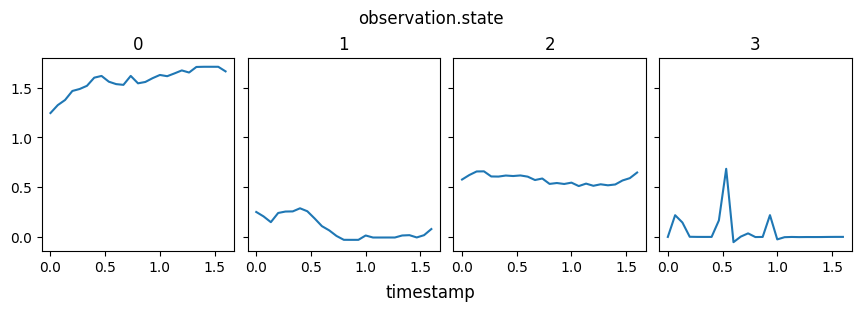

In [8]:
from importlib import reload
import gym_lite6.utils
import mediapy as media

reload(gym_lite6.utils)

ep_idx = 1
from_idx, to_idx = dataset.episode_data_index["from"][ep_idx].item(), dataset.episode_data_index["to"][ep_idx].item()
fps = 1/(dataset[from_idx+1]["timestamp"] - dataset[from_idx]["timestamp"])

gym_lite6.utils.plot_dict_of_arrays(dataset.hf_dataset[from_idx:to_idx], "timestamp", ["observation.state"])
media.show_video(torch.stack([dataset[i]["observation.image"] for i in range(from_idx, to_idx)], dim=0).permute(0,2,3,1).numpy(), fps=fps, width=400)


In [7]:
import numpy as np

dataset.hf_dataset[:10]["observation.state"]

[tensor([ 1.3107e+00,  2.9643e-01,  5.4433e-01, -1.7637e-05]),
 tensor([ 1.3997e+00,  2.1559e-01,  6.2846e-01, -2.2419e-05]),
 tensor([ 1.4805e+00,  2.9053e-01,  5.4837e-01, -5.4690e-04]),
 tensor([ 1.5382,  0.2251,  0.5126, -0.0073]),
 tensor([1.5758, 0.3098, 0.5798, 0.2313]),
 tensor([1.6043, 0.2875, 0.5854, 0.8755]),
 tensor([1.6028, 0.2969, 0.5274, 0.4764]),
 tensor([ 1.6910,  0.2080,  0.6040, -0.0069]),
 tensor([1.7043, 0.1686, 0.6842, 0.3983]),
 tensor([1.7044, 0.1891, 0.6597, 0.8460])]

In [104]:
lerobot.available_policies

['act', 'diffusion', 'tdmpc', 'vqbet']

In [9]:
from lerobot.common.policies.diffusion.modeling_diffusion import DiffusionPolicy, DiffusionConfig
from lerobot.common.datasets.utils import dataset_to_policy_features
from lerobot.configs.types import FeatureType

features = dataset_to_policy_features(dataset.meta.features)
output_features = {key: ft for key, ft in features.items() if ft.type is FeatureType.ACTION}
input_features = {key: ft for key, ft in features.items() if key not in output_features}
policy_cfg = DiffusionConfig(input_features=input_features, output_features=output_features)

policy = DiffusionPolicy.from_pretrained()

TypeError: PreTrainedPolicy.from_pretrained() missing 1 required positional argument: 'pretrained_name_or_path'

In [ ]:
DiffusionPolicy.from_pretrained("lerobot/xarm_lift_medium")

In [ ]:
# from lerobot.common.policies.tdmpc.modeling_tdmpc import TDMPCConfig, TDMPCPolicy
# from lerobot.common.datasets.utils import dataset_to_policy_features
# from lerobot.configs.types import FeatureType

device = "cuda"

# features = dataset_to_policy_features(dataset.meta.features)
# output_features = {key: ft for key, ft in features.items() if ft.type is FeatureType.ACTION}
# input_features = {key: ft for key, ft in features.items() if key not in output_features}
# policy_cfg = TDMPCConfig(input_features=input_features, output_features=output_features)

# policy_cfg = TDMPCConfig(
#     input_features=input_features,
#     output_features=output_features,
#     # use_mpc=True
# )

policy = TDMPCPolicy(policy_cfg, dataset_stats=dataset.meta.stats)
policy.train()
policy.to(device)

optimizer = torch.optim.Adam(policy.parameters(), lr=1e-4)


In [38]:
import torch

dataloader = torch.utils.data.DataLoader(
    dataset,
    num_workers=1,
    batch_size=64,
    shuffle=True,
    pin_memory=device != torch.device("cpu"),
    drop_last=True,
)

In [39]:
# import tracemalloc

# tracemalloc.start()
training_steps = 5000

step = 0
done = False
while not done:
    for batch in dataloader:
        # batch["observation.state"] = torch.cat([batch["observation.state.qpos"], batch["observation.state.gripper"].unsqueeze(2)], 2)
        batch = {k: v.to(device, non_blocking=True) for k, v in batch.items() if k not in ['task']}
        output_dict = policy.forward(batch)
        loss, _ = output_dict
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()        

        if step % 250 == 0:
            print(f"step: {step} loss: {loss.item():.3f}")
        step += 1
        if step >= training_steps:
            done = True
            break
        # dataset.hf_dataset.clear_cache()
        
# snapshot = tracemalloc.take_snapshot()
# top_stats = snapshot.statistics('lineno')  # Get statistics by line number
# for stat in top_stats[:10]:  # Show top 10 memory allocations
#     print(stat)
# tracemalloc.stop()  # Stop tracing
policy.save_pretrained(f"ckpts/grasp_and_lift_diffusion_step_{step}")


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0xfffed87130a0>
Traceback (most recent call last):
  File "/home/eugene/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/home/eugene/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


step: 0 loss: 0.871


KeyboardInterrupt: 

## Eval

In [19]:
device = "cuda"
policy = TDMPCPolicy.from_pretrained("ckpts/xarm_tdmpc_step_5000")
policy.to(device)

# def eval():
numpy_observation, info = env.reset()
rewards = []
frames = [numpy_observation["pixels"].squeeze()]
done = False
observation = {}

while not done:    
    observation["observation.state"] = torch.from_numpy(numpy_observation["agent_pos"]).to(torch.float32).to(device, non_blocking=True)
    
    observation["observation.image"] = torch.from_numpy(numpy_observation["pixels"]).to(torch.float32).permute((0,3,1,2))
    observation["observation.image"] = (observation["observation.image"]/255).to(device, non_blocking=True)
    # observation["observation.state"] = (observation["observation.state"]/255).to(device, non_blocking=True)

    action = policy.select_action(observation)
    numpy_observation, reward, terminated, truncated, info = env.step(action.cpu().numpy())

    rewards.append(reward)
    frames.append(numpy_observation["pixels"].squeeze())

    done = terminated | truncated

media.show_video(frames, width=200)



Loading weights from local directory


In [22]:
pprint(policy.config)

TDMPCConfig(n_obs_steps=1,
            normalization_mapping={'ACTION': <NormalizationMode.MIN_MAX: 'MIN_MAX'>,
                                   'ENV': <NormalizationMode.IDENTITY: 'IDENTITY'>,
                                   'STATE': <NormalizationMode.IDENTITY: 'IDENTITY'>,
                                   'VISUAL': <NormalizationMode.IDENTITY: 'IDENTITY'>},
            input_features={'observation.image': PolicyFeature(type=<FeatureType.VISUAL: 'VISUAL'>,
                                                               shape=(3,
                                                                      84,
                                                                      84)),
                            'observation.state': PolicyFeature(type=<FeatureType.STATE: 'STATE'>,
                                                               shape=(4,))},
            output_features={'action': PolicyFeature(type=<FeatureType.ACTION: 'ACTION'>,
                                          

{'batch_size': 64,
 'dataset': {'episodes': None,
             'image_transforms': {'enable': False,
                                  'max_num_transforms': 3,
                                  'random_order': False,
                                  'tfs': {'brightness': {'kwargs': {'brightness': [0.8,
                                                                                   1.2]},
                                                         'type': 'ColorJitter',
                                                         'weight': 1.0},
                                          'contrast': {'kwargs': {'contrast': [0.8,
                                                                               1.2]},
                                                       'type': 'ColorJitter',
                                                       'weight': 1.0},
                                          'hue': {'kwargs': {'hue': [-0.05,
                                                                     0.05]},
                                                  'type': 'ColorJitter',
                                                  'weight': 1.0},
                                          'saturation': {'kwargs': {'saturation': [0.5,
                                                                                   1.5]},
                                                         'type': 'ColorJitter',
                                                         'weight': 1.0},
                                          'sharpness': {'kwargs': {'sharpness': [0.5,
                                                                                 1.5]},
                                                        'type': 'SharpnessJitter',
                                                        'weight': 1.0}}},
             'repo_id': 'lerobot/xarm_lift_medium',
             'revision': None,
             'root': None,
             'use_imagenet_stats': True,
             'video_backend': 'pyav'},
 'env': None,
 'eval': {'batch_size': 50, 'n_episodes': 50, 'use_async_envs': False},
 'eval_freq': 20000,
 'job_name': 'tdmpc',
 'log_freq': 200,
 'num_workers': 4,
 'optimizer': {'betas': [0.9, 0.999],
               'eps': 1e-08,
               'grad_clip_norm': 10.0,
               'lr': 0.0003,
               'type': 'adam',
               'weight_decay': 0.0},
 'output_dir': 'outputs/train/xarm_tdmpc',
 'policy': {'advantage_scaling': 3.0,
            'cem_iterations': 6,
            'consistency_coeff': 20.0,
            'device': 'cuda',
            'discount': 0.9,
            'elite_weighting_temperature': 0.5,
            'expectile_weight': 0.9,
            'gaussian_mean_momentum': 0.1,
            'horizon': 5,
            'image_encoder_hidden_dim': 32,
            'input_features': {},
            'latent_dim': 50,
            'max_random_shift_ratio': 0.0476,
            'max_std': 2.0,
            'min_std': 0.05,
            'mlp_dim': 512,
            'n_action_repeats': 2,
            'n_action_steps': 1,
            'n_elites': 50,
            'n_gaussian_samples': 512,
            'n_obs_steps': 1,
            'n_pi_samples': 51,
            'normalization_mapping': {'ACTION': <NormalizationMode.MIN_MAX: 'MIN_MAX'>,
                                      'ENV': <NormalizationMode.IDENTITY: 'IDENTITY'>,
                                      'STATE': <NormalizationMode.IDENTITY: 'IDENTITY'>,
                                      'VISUAL': <NormalizationMode.IDENTITY: 'IDENTITY'>},
            'optimizer_lr': 0.0003,
            'output_features': {},
            'pi_coeff': 0.5,
            'q_ensemble_size': 5,
            'reward_coeff': 0.5,
            'state_encoder_hidden_dim': 256,
            'target_model_momentum': 0.995,
            'temporal_decay_coeff': 0.5,
            'type': 'tdmpc',
            'uncertainty_regularizer_coeff': 1.0,
            'use_amp': False,
            'use_mpc': True,
            'value_coeff': 0.1},
 'resume': False,
 'save_checkpoint': True,
 'save_freq': 20000,
 'scheduler': None,
 'seed': 1000,
 'steps': 50000,
 'use_policy_training_preset': True,
 'wandb': {'disable_artifact': False,
           'enable': False,
           'entity': None,
           'notes': None,
           'project': 'lerobot'}}

# Aloha

In [1]:
import torch
import lerobot
from lerobot.common.datasets.lerobot_dataset import LeRobotDataset, LeRobotDatasetMetadata
from pprint import pprint
from lerobot.common.policies.act.modeling_act import ACTConfig, ACTPolicy
from lerobot.common.envs.configs import AlohaEnv
from lerobot.common.datasets.utils import dataset_to_policy_features
from lerobot.configs.types import FeatureType
import mediapy as media
from lerobot.common.datasets.factory import make_dataset
import lerobot.common.envs.factory


/media/ssd/eugene/robotic_manipulation/lerobot_venv/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [ ]:

dataset_metadata = LeRobotDatasetMetadata("lerobot/aloha_sim_transfer_cube_scripted")
features = dataset_to_policy_features(dataset_metadata.features)
output_features = {key: ft for key, ft in features.items() if ft.type is FeatureType.ACTION}
input_features = {key: ft for key, ft in features.items() if key not in output_features}

# Create TDMPC config
# cfg = TDMPCConfig(
#     input_features=input_features,
#     output_features=output_features,
#     # use_mpc=True,
# )
cfg = ACTConfig(input_features=input_features, output_features=output_features)
# env = AlohaEnv(task="AlohaTransferCube-v0")

delta_timestamps = {
    "action": [i / dataset_metadata.fps for i in cfg.action_delta_indices],
}
dataset = LeRobotDataset("lerobot/aloha_sim_transfer_cube_scripted", delta_timestamps=delta_timestamps)

# requires mujoco 3.3.1 w dm_control 1.0.28
# env_cfg = lerobot.common.envs.factory.make_env_config("aloha", task="AlohaTransferCube-v0")
# env = lerobot.common.envs.factory.make_env(env_cfg)

device = "cuda"
policy = ACTPolicy(cfg, dataset_metadata.stats)
policy.to(device)
policy.train()
step = 0


Resolving data files:   0%|          | 0/50 [00:00<?, ?it/s]

AttributeError: 'MjModel' object has no attribute 'flex_xvert0'

In [4]:
import gymnasium as gym
gym.pprint_registry()

===== classic_control =====
Acrobot-v1                                                    CartPole-v0                                                   CartPole-v1
MountainCar-v0                                                MountainCarContinuous-v0                                      Pendulum-v1
===== phys2d =====
phys2d/CartPole-v0                                            phys2d/CartPole-v1                                            phys2d/Pendulum-v0
===== box2d =====
BipedalWalker-v3                                              BipedalWalkerHardcore-v3                                      CarRacing-v2
LunarLander-v2                                                LunarLanderContinuous-v2
===== toy_text =====
Blackjack-v1                                                  CliffWalking-v0                                               FrozenLake-v1
FrozenLake8x8-v1                                              Taxi-v3
===== tabular =====
tabular/Blackjack-v0                           

In [7]:
gym.make("gym_aloha/AlohaTransferCube-v0")

AttributeError: 'MjModel' object has no attribute 'flex_interp'

In [4]:
dataset[0]

{'observation.images.top': tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],
 
         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],
 
         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]),
 'observation.state': tensor([ 0.0000, -0.9600,  1.1600,  0.0000, -0.3000,  0.0000,  0.0998,  0.0000,
         -0.9600,  1.1600,  0.0000, -0.3000,  0.0000,  0.0998]

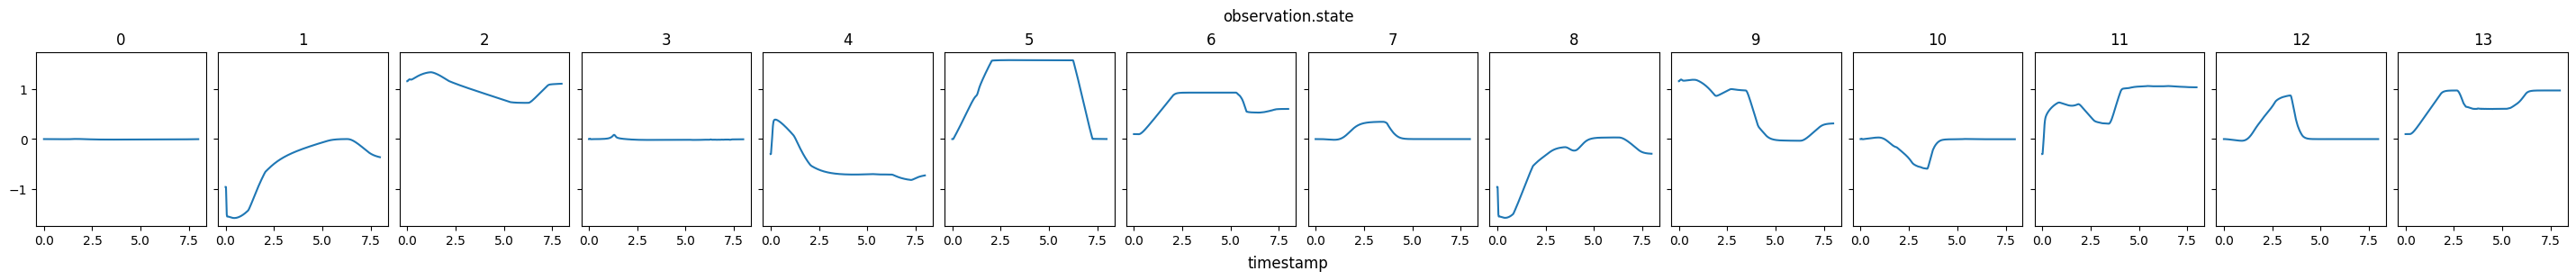

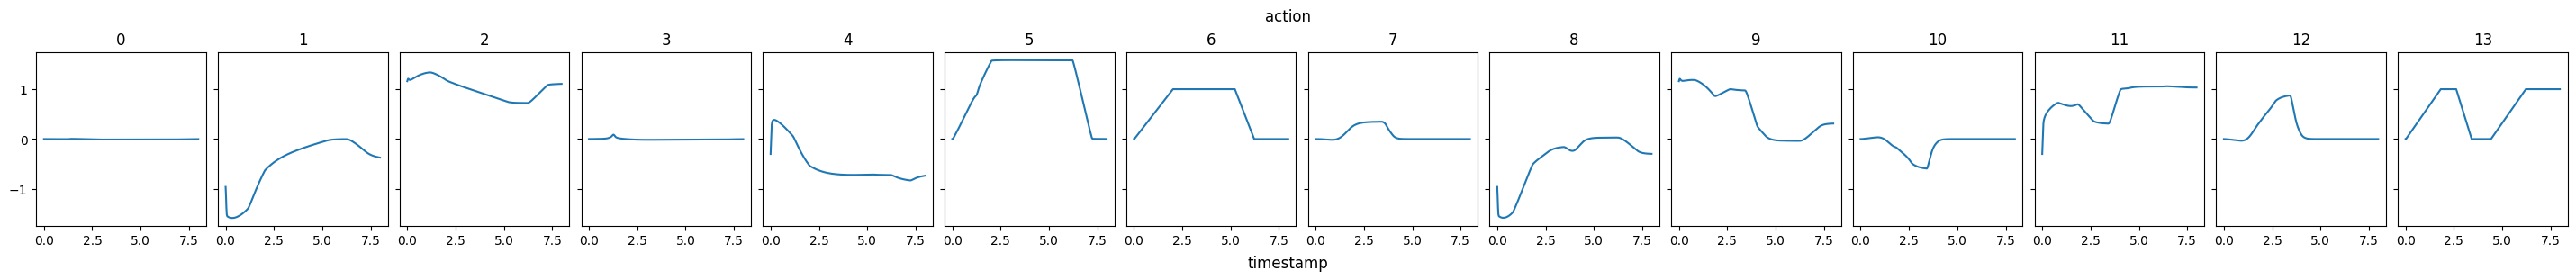

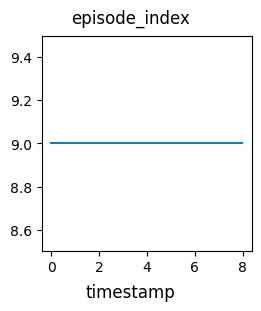

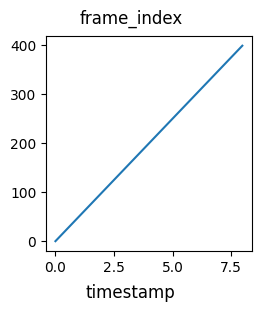

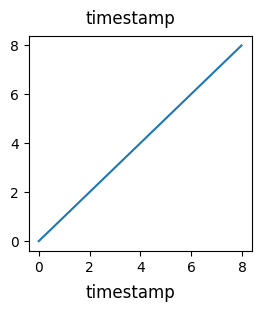

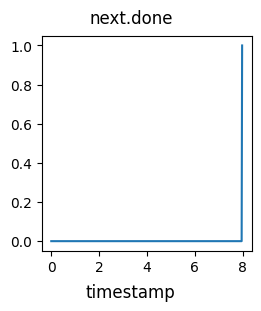

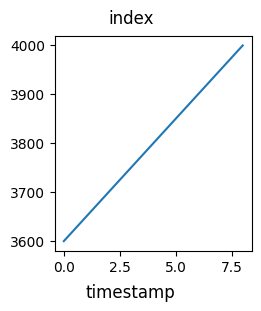

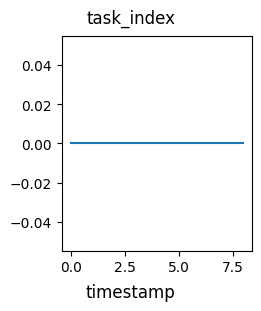

In [7]:
from importlib import reload
import gym_lite6.utils

# reload(gym_lite6.utils)

ep_idx = 9
from_idx, to_idx = dataset.episode_data_index["from"][ep_idx].item(), dataset.episode_data_index["to"][ep_idx].item()
fps = 1/(dataset[from_idx+1]["timestamp"] - dataset[from_idx]["timestamp"])

gym_lite6.utils.plot_dict_of_arrays(dataset.hf_dataset[from_idx:to_idx], "timestamp", ["observation.state", 'action', 'episode_index', 'frame_index', 'timestamp', 'next.done', 'index', 'task_index'])
media.show_video(torch.stack([dataset[i]["observation.images.top"] for i in range(from_idx, to_idx)], dim=0).permute(0,2,3,1).numpy(), fps=fps, width=400)


In [8]:
dataset

LeRobotDataset({
    Repository ID: 'lerobot/aloha_sim_transfer_cube_scripted',
    Number of selected episodes: '50',
    Number of selected samples: '20000',
    Features: '['observation.images.top', 'observation.state', 'action', 'episode_index', 'frame_index', 'timestamp', 'next.done', 'index', 'task_index']',
})',

In [14]:
optim_params = policy.get_optim_params() # if cfg.use_policy_training_preset else policy.parameters()
# policy.get_optimizer_preset()
# scheduler = cfg.get_scheduler_preset().build(optim_params)
optimizer = cfg.get_optimizer_preset().build(optim_params)

dataloader = torch.utils.data.DataLoader(
    dataset,
    num_workers=1,
    batch_size=64,
    shuffle=True,
    pin_memory=device != torch.device("cpu"),
    drop_last=True,
)

In [7]:
pprint(policy.config)

ACTConfig(n_obs_steps=1,
          normalization_mapping={'ACTION': <NormalizationMode.MEAN_STD: 'MEAN_STD'>,
                                 'STATE': <NormalizationMode.MEAN_STD: 'MEAN_STD'>,
                                 'VISUAL': <NormalizationMode.MEAN_STD: 'MEAN_STD'>},
          input_features={'observation.images.top': PolicyFeature(type=<FeatureType.VISUAL: 'VISUAL'>,
                                                                  shape=(3,
                                                                         480,
                                                                         640)),
                          'observation.state': PolicyFeature(type=<FeatureType.STATE: 'STATE'>,
                                                             shape=(14,))},
          output_features={'action': PolicyFeature(type=<FeatureType.ACTION: 'ACTION'>,
                                                   shape=(14,))},
          device='cuda',
          use_amp=False,
       

In [15]:


num_steps = 10000
dl_iter = iter(dataloader)
for _ in range(step, num_steps):
    try:
        batch = next(dl_iter)
    except StopIteration:
        dl_iter = iter(dataloader)
        batch = next(dl_iter)
    
    for key in batch:
        if isinstance(batch[key], torch.Tensor):
            batch[key] = batch[key].to(device, non_blocking=True)
    loss, output_dict = policy.forward(batch)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    if step % 250 == 0:
        print(f"step: {step} loss: {loss.item():.3f}")
    if step % 1000 == 0:
        policy.save_pretrained(f"ckpts/act_aloha_step_{step}")
    step += 1

policy.save_pretrained(f"ckpts/act_aloha_step_{step}")
    

step: 2000 loss: 0.093
step: 2250 loss: 0.025
step: 2500 loss: 0.023
step: 2750 loss: 0.020
step: 3000 loss: 0.021
step: 3250 loss: 0.025
step: 3500 loss: 0.018
step: 3750 loss: 0.015
step: 4000 loss: 0.021
step: 4250 loss: 0.015
step: 4500 loss: 0.016
step: 4750 loss: 0.016
step: 5000 loss: 0.015
step: 5250 loss: 0.013
step: 5500 loss: 0.013
step: 5750 loss: 0.013
step: 6000 loss: 0.013


Parameter 'indices'=[6868, 6869, 6870, 6871, 6872, 6873, 6874, 6875, 6876, 6877, 6878, 6879, 6880, 6881, 6882, 6883, 6884, 6885, 6886, 6887, 6888, 6889, 6890, 6891, 6892, 6893, 6894, 6895, 6896, 6897, 6898, 6899, 6900, 6901, 6902, 6903, 6904, 6905, 6906, 6907, 6908, 6909, 6910, 6911, 6912, 6913, 6914, 6915, 6916, 6917, 6918, 6919, 6920, 6921, 6922, 6923, 6924, 6925, 6926, 6927, 6928, 6929, 6930, 6931, 6932, 6933, 6934, 6935, 6936, 6937, 6938, 6939, 6940, 6941, 6942, 6943, 6944, 6945, 6946, 6947, 6948, 6949, 6950, 6951, 6952, 6953, 6954, 6955, 6956, 6957, 6958, 6959, 6960, 6961, 6962, 6963, 6964, 6965, 6966, 6967] of the transform datasets.arrow_dataset.Dataset.select couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything.

KeyboardInterrupt: 

In [9]:
device = "cuda"
step = 6000
policy = ACTPolicy.from_pretrained(f"ckpts/act_aloha_step_{step}")
policy.to(device)

# def eval():
numpy_observation, info = env.reset()
rewards = []
frames = [numpy_observation["pixels"]["top"].squeeze()]
done = False
observation = {}

while not done:    
    observation["observation.state"] = torch.from_numpy(numpy_observation["agent_pos"]).to(torch.float32).to(device, non_blocking=True)
    
    observation["observation.images.top"] = torch.from_numpy(numpy_observation["pixels"]["top"]).to(torch.float32).permute((0,3,1,2))
    observation["observation.images.top"] = (observation["observation.images.top"]/255).to(device, non_blocking=True)
    # observation["observation.state"] = (observation["observation.state"]/255).to(device, non_blocking=True)

    action = policy.select_action(observation)
    numpy_observation, reward, terminated, truncated, info = env.step(action.cpu().numpy())

    rewards.append(reward)
    frames.append(numpy_observation["pixels"]["top"].squeeze())

    done = terminated | truncated

media.show_video(frames, width=200)



Loading weights from local directory


NameError: name 'env' is not defined

In [11]:
policy

ACTPolicy(
  (normalize_inputs): Normalize(
    (buffer_observation_images_top): ParameterDict(
        (mean): Parameter containing: [torch.cuda.FloatTensor of size 3x1x1 (cuda:0)]
        (std): Parameter containing: [torch.cuda.FloatTensor of size 3x1x1 (cuda:0)]
    )
    (buffer_observation_state): ParameterDict(
        (mean): Parameter containing: [torch.cuda.FloatTensor of size 14 (cuda:0)]
        (std): Parameter containing: [torch.cuda.FloatTensor of size 14 (cuda:0)]
    )
  )
  (normalize_targets): Normalize(
    (buffer_action): ParameterDict(
        (mean): Parameter containing: [torch.cuda.FloatTensor of size 14 (cuda:0)]
        (std): Parameter containing: [torch.cuda.FloatTensor of size 14 (cuda:0)]
    )
  )
  (unnormalize_outputs): Unnormalize(
    (buffer_action): ParameterDict(
        (mean): Parameter containing: [torch.cuda.FloatTensor of size 14 (cuda:0)]
        (std): Parameter containing: [torch.cuda.FloatTensor of size 14 (cuda:0)]
    )
  )
  (model): 

In [8]:
policy.config

NameError: name 'policy' is not defined